In [1]:
#importing libraries
import warnings
warnings.filterwarnings("ignore")

from bs4 import BeautifulSoup
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
#filtering only positive and negative reviews i.e. not taking into consideration those reviews with Score=3 
#SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points 
#you can change the number to any other number based on your computing power

con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con)

In [3]:
#map() function returns a list of the results after applying the given function to each item of a given iterable (list, tuple etc.) 
#https://www.geeksforgeeks.org/python-map-function/
# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be negative and greater than 3 to be positive
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
#It is observed (as shown in the table below) that the reviews data had many duplicate entries. 
#Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. 
#Following is an example:
display = pd.read_sql_query("""
SELECT * FROM Reviews
WHERE Score!=3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductId
""",con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html
final = filtered_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"} ,keep='first' ,inplace=False)
print(final.shape)

(46072, 10)


In [6]:
#checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

In [7]:
#It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [8]:
print(final.shape)

(46072, 10)


# Preprocessing Review Text
**Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.**
1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)

In [9]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
# https://stackoverflow.com/a/47091490/4084039
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
#https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
#https://stackoverflow.com/a/18082370/4084039
#https://stackoverflow.com/a/5843547/4084039
#https://tqdm.github.io/docs/tqdm/
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance) #removing the urls
    sentance = BeautifulSoup(sentance, 'lxml').get_text() #removing html text
    sentance = decontracted(sentance) #word is made up of english letters and is not alpha-numeric
    sentance = re.sub("\S*\d\S*", "", sentance).strip() #removing words with numbers
    sentance = re.sub('[^A-Za-z]+', ' ', sentance) #removing spacial character
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46072/46072 [00:22<00:00, 2058.82it/s]


In [12]:
preprocessed_reviews[1500]

'aboulutely love popchips first tried healthy chips marathon california like variety pack got try alot flavors ive never'

In [13]:
# Similartly you can do preprocessing for review summary also.
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 46072/46072 [00:14<00:00, 3206.90it/s]


In [14]:
#bag of words
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
count_vect = CountVectorizer()
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46072, 39365)
the number of unique words  39365


In [15]:
#bi-gram, tri-gram and n-gram
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46072, 5000)
the number of unique words including both unigrams and bigrams  5000


In [16]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
#Convert a collection of raw documents to a matrix of TF-IDF features.
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaaaahhhhhh', 'aaaaaawwwwwwwwww', 'aaaaah', 'aaaand']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (46072, 39365)
the number of unique words including both unigrams and bigrams  39365


In [17]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [18]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance, min_count=5, size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8251963257789612), ('awesome', 0.820135235786438), ('good', 0.79222571849823), ('excellent', 0.7915909290313721), ('perfect', 0.7721242308616638), ('wonderful', 0.7587900757789612), ('terrific', 0.7450492978096008), ('amazing', 0.7216590642929077), ('decent', 0.6902945637702942), ('nice', 0.6815996766090393)]
[('nastiest', 0.7469146847724915), ('experienced', 0.7232357263565063), ('greatest', 0.7107484340667725), ('best', 0.6941331028938293), ('awful', 0.6681792736053467), ('tastiest', 0.6513611674308777), ('softest', 0.6459216475486755), ('closest', 0.64020174741745), ('ive', 0.627759575843811), ('disgusting', 0.6264868378639221)]


In [19]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  12798
sample words  ['bought', 'several', 'vitality', 'canned', 'dog', 'food', 'products', 'found', 'good', 'quality', 'product', 'looks', 'like', 'stew', 'processed', 'meat', 'smells', 'better', 'labrador', 'finicky', 'appreciates', 'arrived', 'labeled', 'jumbo', 'salted', 'peanuts', 'actually', 'small', 'sized', 'unsalted', 'not', 'sure', 'error', 'vendor', 'intended', 'represent', 'confection', 'around', 'centuries', 'light', 'citrus', 'gelatin', 'nuts', 'case', 'cut', 'tiny', 'squares', 'liberally', 'coated', 'powdered']


In [20]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 46072/46072 [01:29<00:00, 515.26it/s]


46072
50


In [21]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [22]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|████████████████████████████████████████████████████████████████████████████| 46072/46072 [19:06<00:00, 39.09it/s]


In [23]:
#Splitting preprocessed reviews into train,cross validation and test
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection  import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection  import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
X = preprocessed_reviews
y = np.array(final['Score'])
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3, random_state = 0)

In [24]:
count_vect = CountVectorizer()
X_train_bow = count_vect.fit_transform(X_train)
X_cv_bow = count_vect.transform(X_cv)
X_test_bow = count_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_bow = scalar.fit_transform(X_train_bow)
X_test_bow = scalar.transform(X_test_bow)
X_cv_bow = scalar.transform(X_cv_bow)

base_learners = [20, 40, 60, 80, 100, 120]
depths = [1, 5, 10, 50, 100, 500, 1000]
param_grid = {'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(rf, param_grid, scoring='roc_auc', n_jobs = -1, cv = 3)
model.fit(X_train_bow, y_train)
optimal_n_estimators1 = model.best_estimator_.n_estimators
optimal_max_depth1 = model.best_estimator_.max_depth
print("best n_estimators", optimal_n_estimators1)
print("best max_depth", optimal_max_depth1)

best n_estimators 120
best max_depth 1000


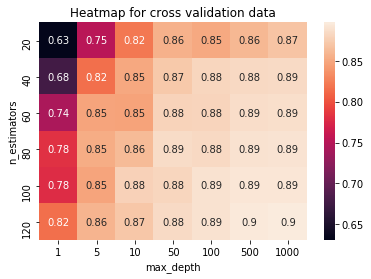

In [25]:
import seaborn as sns
X = []
Y = []
auc_cv = []
auc_train = []
for bl in base_learners:
    for d in depths:
        rf = RandomForestClassifier(max_features = 'sqrt', max_depth = d, n_estimators = bl)
        rf.fit(X_train_bow, y_train)
        pred = rf.predict_proba(X_cv_bow)[:,1]
        predt = rf.predict_proba(X_train_bow)[:,1]
        X.append(bl)
        Y.append(d)
        auc_cv.append(roc_auc_score(y_cv,pred))
        auc_train.append(roc_auc_score(y_train,predt))
        
#heatmap for cv data
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_cv})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted, annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

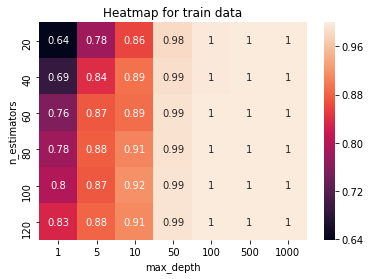

In [26]:
#heatmap for train data
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_train})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted, annot=True)
plt.title('Heatmap for train data')
plt.show()

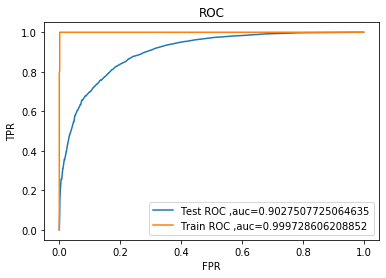

In [27]:
#roc curve
rf = RandomForestClassifier(max_features = 'sqrt', max_depth = optimal_max_depth1, n_estimators = optimal_n_estimators1)
rf.fit(X_train_bow,y_train)
predi = rf.predict_proba(X_test_bow)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred = rf.predict_proba(X_train_bow)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred)
auc1 = roc_auc_score(y_test,predi)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc=' + str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc=' + str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

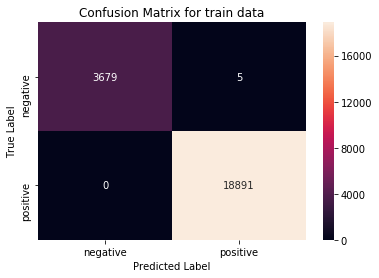

In [28]:
#Confusion matrix using heatmap for train data
predic = rf.predict(X_train_bow)
conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

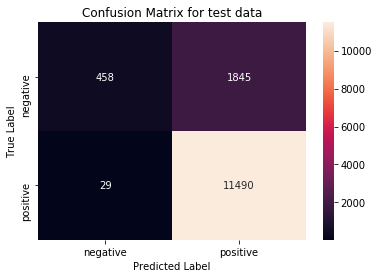

In [29]:
#Confusion matrix using heatmap for test data
predic = rf.predict(X_test_bow)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

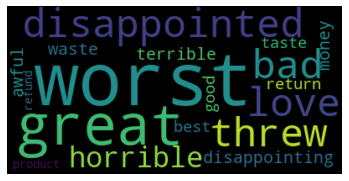

In [30]:
#Wordcloud of top 20 important features from
all_features = count_vect.get_feature_names()
data = ''
feat = rf.feature_importances_
features = np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=all_features[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [33]:
#Applying Random Forests on TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
X_train_tf = tf_idf_vect.fit_transform(X_train)
X_cv_tf = tf_idf_vect.transform(X_cv)
X_test_tf = tf_idf_vect.transform(X_test)

scalar = StandardScaler(with_mean=False)
X_train_tf = scalar.fit_transform(X_train_tf)
X_test_tf = scalar.transform(X_test_tf)
X_cv_tf = scalar.transform(X_cv_tf)


base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]
param_grid={'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features = 'sqrt')
model = GridSearchCV(rf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 3)
model.fit(X_train_tf,y_train)
optimal_max_depth2 = model.best_estimator_.max_depth
optimal_n_estimators2 = model.best_estimator_.n_estimators 
print("best n_estimators",optimal_n_estimators2)
print("best max_depth",optimal_max_depth2)

best n_estimators 120
best max_depth 1000


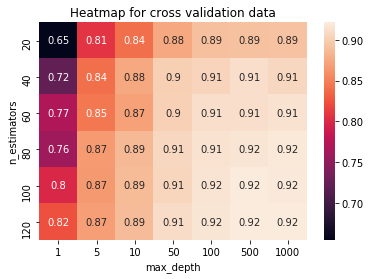

In [34]:
import seaborn as sns
X = []
Y = []
auc_cv = []
auc_train = []
for bl in base_learners:
    for d in depths:
        rf = RandomForestClassifier(max_features = 'sqrt', max_depth = d, n_estimators = bl)
        rf.fit(X_train_tf,y_train)
        pred = rf.predict_proba(X_cv_tf)[:,1]
        predt = rf.predict_proba(X_train_tf)[:,1]
        X.append(bl)
        Y.append(d)
        auc_cv.append(roc_auc_score(y_cv,pred))
        auc_train.append(roc_auc_score(y_train,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_cv})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

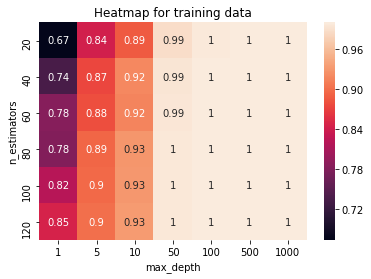

In [35]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_train})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted, annot=True)
plt.title('Heatmap for training data')
plt.show()

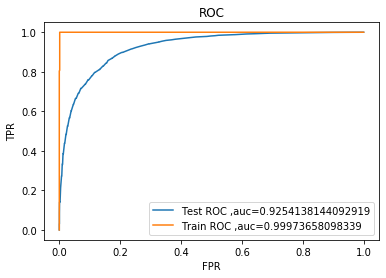

In [36]:
#roc curve
rf = RandomForestClassifier(max_features = 'sqrt', max_depth = optimal_max_depth2, n_estimators = optimal_n_estimators2)
rf.fit(X_train_tf,y_train)
predi = rf.predict_proba(X_test_tf)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred = rf.predict_proba(X_train_tf)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred)
auc2 = roc_auc_score(y_test,predi)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc=' + str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc=' + str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

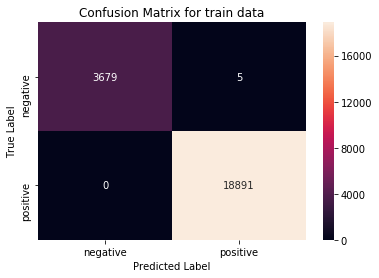

In [37]:
#Confusion matrix using heatmap for train data
predic = rf.predict(X_train_tf)
conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

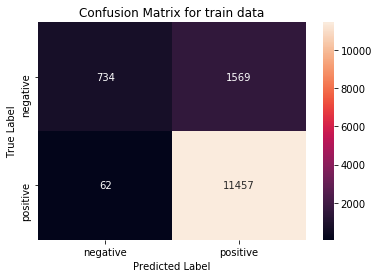

In [38]:
#Confusion matrix using heatmap for test data
predic = rf.predict(X_test_tf)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

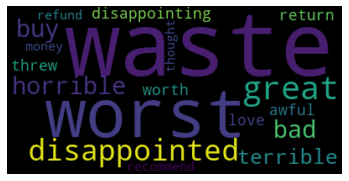

In [39]:
#Wordcloud of top 20 important features from
all_features = tf_idf_vect.get_feature_names()
data = ''
feat = rf.feature_importances_
features = np.argsort(feat)[::-1]
for i in features[0:20]:
    data+=all_features[i]
    data+=' '
    
    
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="black").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [40]:
#Applying Random Forests on AVG W2V
#word2vec for train
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

#for cross validation we can use same w2v models and w2v words
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
sent_vectors_cv = []; 
for sent in tqdm(list_of_sentance_cv):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))   

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
sent_vectors_test = []; 
for sent in tqdm(list_of_sentance_test):
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|███████████████████████████████████████████████████████████████████████████| 22575/22575 [00:43<00:00, 517.19it/s]


22575
50


100%|█████████████████████████████████████████████████████████████████████████████| 9675/9675 [00:19<00:00, 494.33it/s]


9675
50


100%|███████████████████████████████████████████████████████████████████████████| 13822/13822 [00:26<00:00, 522.60it/s]


13822
50


In [41]:
X_train_w2v = sent_vectors_train
X_cv_w2v = sent_vectors_cv
X_test_w2v = sent_vectors_test

base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]
param_grid = {'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features = 'sqrt')
model = GridSearchCV(rf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 3)
model.fit(X_train_w2v, y_train)
optimal_max_depth3 = model.best_estimator_.max_depth
optimal_n_estimators3 = model.best_estimator_.n_estimators
print("best n_estimators", optimal_n_estimators3)
print("best max_depth",optimal_max_depth3)

best n_estimators 120
best max_depth 100


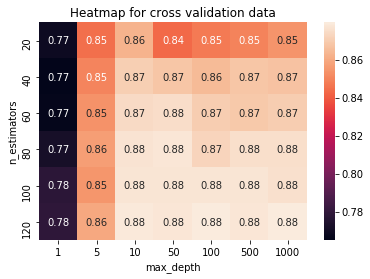

In [42]:
X = []
Y = []
auc_cv = []
auc_train = []
for bl in base_learners:
    for d in depths:
        rf = RandomForestClassifier(max_features = 'sqrt', max_depth = d, n_estimators = bl)
        rf.fit(X_train_w2v,y_train)
        pred = rf.predict_proba(X_cv_w2v)[:,1]
        predt = rf.predict_proba(X_train_w2v)[:,1]
        X.append(bl)
        Y.append(d)
        auc_cv.append(roc_auc_score(y_cv,pred))
        auc_train.append(roc_auc_score(y_train,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_cv})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

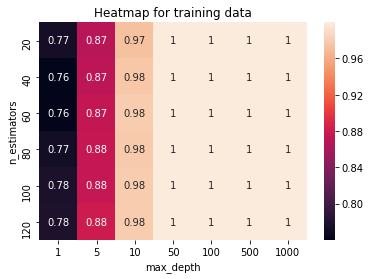

In [43]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_train})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for training data')
plt.show()

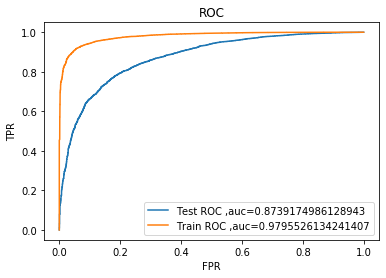

In [44]:
#roc curve
rf = RandomForestClassifier(max_features = 'sqrt', max_depth = 10, n_estimators = 100)
rf.fit(X_train_w2v,y_train)
predi = rf.predict_proba(X_test_w2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred = rf.predict_proba(X_train_w2v)[:,1]
fpr2,tpr2,thresholds2 = metrics.roc_curve(y_train,pred)
fig = plt.figure()
auc3 = roc_auc_score(y_test,predi)
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label='Test ROC ,auc=' + str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label='Train ROC ,auc=' + str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

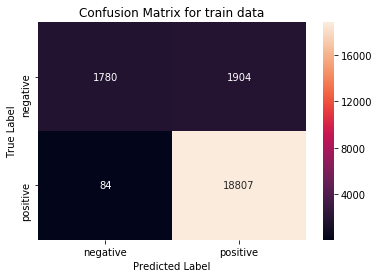

In [45]:
#Confusion matrix using heatmap for train data
predic = rf.predict(X_train_w2v)
conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

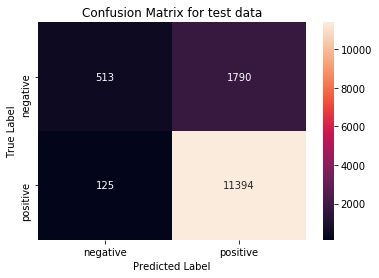

In [46]:
#Confusion matrix using heatmap for test data
predic = rf.predict(X_test_w2v)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [47]:
#Applying Random Forests on TFIDF W2V
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4) 
w2v_words = list(w2v_model.wv.vocab)
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=10, max_features=500)

tf_idf_matrix=tf_idf_vect.fit_transform(X_train)


tfidf_feat = tf_idf_vect.get_feature_names() 
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

#for train data

tfidf_sent_vectors_train = []; 
row=0;
for sent in tqdm(list_of_sentance_train): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

#for cross validation data and test we will use same words and models of train
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
tfidf_sent_vectors_cv = []; 
row=0;
for sent in tqdm(list_of_sentance_cv): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

#for test data
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())
tfidf_sent_vectors_test = []; 
row=0;
for sent in tqdm(list_of_sentance_test): 
    sent_vec = np.zeros(50)
    weight_sum =0;
    for word in sent: 
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|███████████████████████████████████████████████████████████████████████████| 13822/13822 [00:27<00:00, 504.49it/s]


In [48]:
X_train_tfw2v = tfidf_sent_vectors_train
X_cv_tfw2v = tfidf_sent_vectors_cv
X_test_tfw2v = tfidf_sent_vectors_test

base_learners = [20,40,60,80,100,120]
depths = [1,5,10,50,100,500,1000]
param_grid = {'n_estimators': base_learners, 'max_depth':depths}
rf = RandomForestClassifier(max_features='sqrt')
model = GridSearchCV(rf, param_grid, scoring = 'roc_auc', n_jobs = -1, cv = 3)
model.fit(X_train_tfw2v,y_train)
optimal_max_depth4 = model.best_estimator_.max_depth
optimal_n_estimators4 =model.best_estimator_.n_estimators
print("best n_estimators",optimal_n_estimators4)
print("best max_depth",optimal_max_depth4)

best n_estimators 120
best max_depth 10


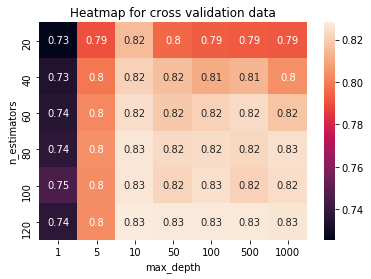

In [49]:
X = []
Y = []
auc_cv = []
auc_train = []
for bl in base_learners:
    for d in depths:
        rf = RandomForestClassifier(max_features = 'sqrt', max_depth = d, n_estimators = bl)
        rf.fit(X_train_tfw2v,y_train)
        pred = rf.predict_proba(X_cv_tfw2v)[:,1]
        predt = rf.predict_proba(X_train_tfw2v)[:,1]
        X.append(bl)
        Y.append(d)
        auc_cv.append(roc_auc_score(y_cv,pred))
        auc_train.append(roc_auc_score(y_train,predt))
        
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_cv})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for cross validation data')
plt.show()

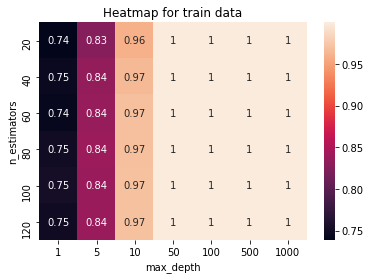

In [50]:
data = pd.DataFrame({'n_estimators': X, 'max_depth': Y, 'AUC': auc_train})
data_pivoted = data.pivot("n_estimators", "max_depth", "AUC")
ax = sns.heatmap(data_pivoted,annot=True)
plt.title('Heatmap for train data')
plt.show()

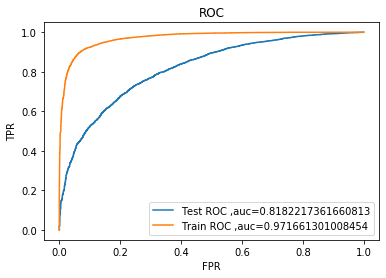

In [51]:
#roc curve
rf = RandomForestClassifier(max_features = 'sqrt', max_depth = optimal_max_depth4, n_estimators = optimal_n_estimators4)
rf.fit(X_train_tfw2v,y_train)
predi = rf.predict_proba(X_test_tfw2v)[:,1]
fpr1, tpr1, thresholds1 = metrics.roc_curve(y_test, predi)
pred = rf.predict_proba(X_train_tfw2v)[:,1]
fpr2,tpr2,thresholds2=metrics.roc_curve(y_train,pred)
auc4 = roc_auc_score(y_test,predi)
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(fpr1, tpr1, label = 'Test ROC ,auc='+str(roc_auc_score(y_test,predi)))
ax.plot(fpr2, tpr2, label = 'Train ROC ,auc='+str(roc_auc_score(y_train,pred)))
plt.title('ROC')
plt.xlabel('FPR')
plt.ylabel('TPR')
ax.legend()
plt.show()

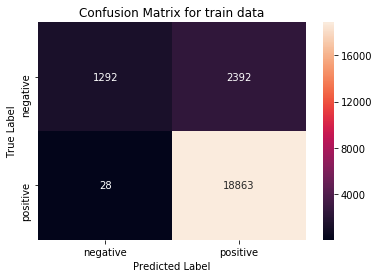

In [52]:
#Confusion matrix using heatmap for train data
predic = rf.predict(X_train_tfw2v)
conf_mat = confusion_matrix(y_train, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for train data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

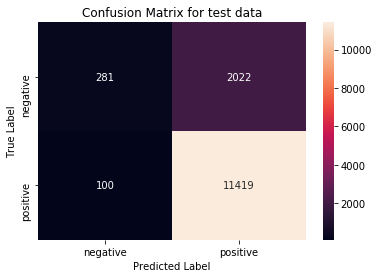

In [53]:
#Confusion matrix using heatmap for test data
predic = rf.predict(X_test_tfw2v)
conf_mat = confusion_matrix(y_test, predic)
class_label = ["negative", "positive"]
df = pd.DataFrame(conf_mat, index = class_label, columns = class_label)
sns.heatmap(df, annot = True, fmt="d")
plt.title("Confusion Matrix for test data")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [55]:
from prettytable import PrettyTable    
x = PrettyTable()
x.field_names = ["Model","Vectorizer","optimal max_depth", "optimal n_estimators", "AUC"]
x.add_row(['Random Forest','BOW',optimal_max_depth1,optimal_n_estimators1,auc1])
x.add_row(['Random Forest','TFIDF',optimal_max_depth2,optimal_n_estimators2,auc2])
x.add_row(['Random Forest','AVG W2vec',optimal_max_depth3,optimal_n_estimators3,auc3])
x.add_row(['Random Forest','TFIDF W2vec',optimal_max_depth4,optimal_n_estimators4,auc4])
print(x)

+---------------+-------------+-------------------+----------------------+--------------------+
|     Model     |  Vectorizer | optimal max_depth | optimal n_estimators |        AUC         |
+---------------+-------------+-------------------+----------------------+--------------------+
| Random Forest |     BOW     |        1000       |         120          | 0.9027507725064635 |
| Random Forest |    TFIDF    |        1000       |         120          | 0.9254138144092919 |
| Random Forest |  AVG W2vec  |        100        |         120          | 0.8739174986128943 |
| Random Forest | TFIDF W2vec |         10        |         120          | 0.8182217361660813 |
+---------------+-------------+-------------------+----------------------+--------------------+
